X-ray Projector Comparison
==========================

This example compares SCICO's native X-ray projection algorithm
to that of the ASTRA Toolbox.

In [1]:
import numpy as np

import jax
import jax.numpy as jnp

from xdesign import Foam, discrete_phantom

from scico import plot
from scico.linop import ParallelFixedAxis2dProjector, XRayProject
from scico.linop.radon_astra import TomographicProjector
from scico.util import Timer
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512


det_count = int(jnp.ceil(jnp.sqrt(2 * N**2)))

x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)

Time projector instantiation.

In [3]:
num_angles = 500
angles = jnp.linspace(0, jnp.pi, num=num_angles, endpoint=False)


timer = Timer()

projectors = {}
timer.start("scico_init")
projectors["scico"] = XRayProject(ParallelFixedAxis2dProjector((N, N), angles))
timer.stop("scico_init")

timer.start("astra_init")
projectors["astra"] = TomographicProjector(
    (N, N), detector_spacing=1.0, det_count=det_count, angles=angles
)
timer.stop("astra_init")

Time first projector application, which might include JIT overhead.

In [4]:
ys = {}
for name, H in projectors.items():
    timer_label = f"{name}_first_proj"
    timer.start(timer_label)
    ys[name] = H @ x_gt
    jax.block_until_ready(ys[name])
    timer.stop(timer_label)

Compute average time for a projector application.

In [5]:
num_repeats = 3
for name, H in projectors.items():
    timer_label = f"{name}_avg_proj"
    timer.start(timer_label)
    for _ in range(num_repeats):
        ys[name] = H @ x_gt
        jax.block_until_ready(ys[name])
    timer.stop(timer_label)
    timer.td[timer_label] /= num_repeats

Display timing results.

On our server, the SCICO projection is more than twice
as fast as ASTRA when both are run on the GPU, and about
10% slower when both are run the CPU.

On our server, using the GPU:
Label               Accum.       Current
-------------------------------------------
astra_avg_proj      4.62e-02 s   Stopped
astra_first_proj    6.92e-02 s   Stopped
astra_init          1.36e-03 s   Stopped
scico_avg_proj      1.61e-02 s   Stopped
scico_first_proj    2.95e-02 s   Stopped
scico_init          1.37e+01 s   Stopped

Using the CPU:
Label               Accum.       Current
-------------------------------------------
astra_avg_proj      9.11e-01 s   Stopped
astra_first_proj    9.16e-01 s   Stopped
astra_init          1.06e-03 s   Stopped
scico_avg_proj      1.03e+00 s   Stopped
scico_first_proj    1.04e+00 s   Stopped
scico_init          1.00e+01 s   Stopped

In [6]:
print(timer)

Label               Accum.       Current
-------------------------------------------
astra_avg_proj      4.03e-02 s   Stopped
astra_first_proj    5.02e-02 s   Stopped
astra_init          1.33e-03 s   Stopped
scico_avg_proj      1.60e-02 s   Stopped
scico_first_proj    1.61e-02 s   Stopped
scico_init          1.01e+01 s   Stopped



Show projections.

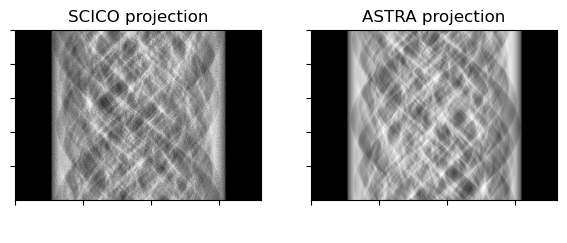

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(7, 3))
plot.imview(ys["scico"], title="SCICO projection", cbar=None, fig=fig, ax=ax[0])
plot.imview(ys["astra"], title="ASTRA projection", cbar=None, fig=fig, ax=ax[1])
fig.show()

Time first back projection, which might include JIT overhead.

In [8]:
timer = Timer()

y = np.zeros(H.output_shape, dtype=np.float32)
y[num_angles // 3, det_count // 2] = 1.0
y = jax.device_put(y)

HTys = {}
for name, H in projectors.items():
    timer_label = f"{name}_first_BP"
    timer.start(timer_label)
    HTys[name] = H.T @ y
    jax.block_until_ready(ys[name])
    timer.stop(timer_label)

Compute average time for back projection.

In [9]:
num_repeats = 3
for name, H in projectors.items():
    timer_label = f"{name}_avg_BP"
    timer.start(timer_label)
    for _ in range(num_repeats):
        HTys[name] = H.T @ y
        jax.block_until_ready(ys[name])
    timer.stop(timer_label)
    timer.td[timer_label] /= num_repeats

Display back projection timing results.

On our server, the SCICO back projection is slow
the first time it is run, probably due to JIT overhead.
After the first run, it is an order of magnitude
faster than ASTRA when both are run on the GPU,
and about three times faster when both are run on the CPU.

On our server, using the GPU:
Label             Accum.       Current
-----------------------------------------
astra_avg_BP      3.71e-02 s   Stopped
astra_first_BP    4.20e-02 s   Stopped
scico_avg_BP      1.05e-03 s   Stopped
scico_first_BP    7.63e+00 s   Stopped

Using the CPU:
Label             Accum.       Current
-----------------------------------------
astra_avg_BP      9.34e-01 s   Stopped
astra_first_BP    9.39e-01 s   Stopped
scico_avg_BP      2.62e-01 s   Stopped
scico_first_BP    1.00e+01 s   Stopped

In [10]:
print(timer)

Label             Accum.       Current
-----------------------------------------
astra_avg_BP      3.84e-02 s   Stopped
astra_first_BP    4.15e-02 s   Stopped
scico_avg_BP      5.62e-04 s   Stopped
scico_first_BP    7.71e+00 s   Stopped



Show back projections of a single detector element,
i.e., a line.

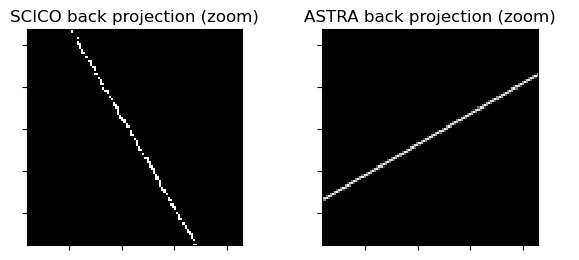

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(7, 3))
plot.imview(HTys["scico"], title="SCICO back projection (zoom)", cbar=None, fig=fig, ax=ax[0])
plot.imview(HTys["astra"], title="ASTRA back projection (zoom)", cbar=None, fig=fig, ax=ax[1])
for ax_i in ax:
    ax_i.set_xlim(2 * N / 5, N - 2 * N / 5)
    ax_i.set_ylim(2 * N / 5, N - 2 * N / 5)
fig.show()